In [265]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import decimal
import scipy.optimize as so
from itertools import product
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
    
import os
import seaborn as sns
import json
import pandas as pd

import scipy.special as sps

from numba import jit
from numba.extending import overload, register_jitable
import matplotlib
from matplotlib.lines import Line2D
from tqdm import tqdm

plt.rc('mathtext', default='regular')

sns.set(context='paper')
sns.set_style("ticks2")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 25
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40

In [6]:
home = os.path.expanduser("~")
project_path =  home+'/Dropbox/Work_main/onset_antigenic_evolution/'
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
import analysis.mathematical_functions.funcs as funcs

In [7]:
def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model
    

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

In [8]:
@jit(nopython=True)
def I_t_numba(fit, t_lim, dt):

    L = int(np.round(t_lim/dt))
    I_t = np.zeros(L)    
    for i in range(L):
        Q=0
        t1 = dt*i
        rho_t = dt*(np.cumsum(-fit[i:L+1])- (-fit[i]) )
        for j in range(i,L):
            S = dt*np.exp(rho_t[j-i])            
            Q+=S
        I_t[i]=Q
    return I_t


def p_surv(fit,t_lim,dt):
    I_t =np.array(I_t_numba(fit,t_lim,dt))
    return 1- I_t/(1+I_t)
            

def product_sum_probas(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = p_surv(fit,t_lim, dt)
        product_sum +=p_d(p_alpha,d)*p_surv_t
    
    return product_sum

In [9]:
class exp_num_datapoint:
    def __init__(self, R0, kappa, xi, p_alpha , N = None, loadsave = False):
        self.R0 = R0
        self.kappa = kappa
        self.xi = xi
        
        if N is None:
            self.N = 1e7
        else:
            self.N = N
        self.p_alpha = p_alpha
        self.ds = np.arange(1,int(10/p_alpha)+1)

        loc = locals()
        loc['N'] = self.N
        
        variable_names = list([l for l in loc if l!='ds'])[1:]### get names of class inputs in order to create an identifier to save the pickle
        variable_values = list([loc[l] for l in loc if l!='ds'])[1:]### get values of class inputs in order to create an identifier to save the pickle
        self.identifier = '_'.join([f'{n}-{v}' for n,v in zip(variable_names,variable_values)])+'_fractional'
        self.initialize(loadsave)

    def find_x_inf(self,R0,k):
        if k>0:
            c = (R0-k+R0*k)/(k*(R0-k))
            rho = 1/(R0/k)
            y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

            roots = so.fsolve(y_x, 0)
            return roots[0]
        else:
            return -1/R0*sps.lambertw(-R0*np.exp(-R0))
        
    def initialize(self, loadsave):
        if loadsave:
            pickle_fol = os.getcwd() + '/pickles/'+self.identifier+'.pkl'
            if os.path.exists(pickle_fol):
                print('Object exists already, loading it')
                pickled_self = self.load_obj(self.identifier+'.pkl')
                for k in pickled_self.__dict__.keys():
                    setattr(self, k, getattr(pickled_self, k))
            else:
                self.integrate_trajectory()
                self.get_exp_num_established()
                print(f'Pickling data')
                self.save_obj(self.identifier)
        else:
            self.x_inf = np.real(self.find_x_inf(self.R0,self.kappa))
            self.integrate_trajectory()
            self.get_exp_num_established()
    
    def save_obj(self, name):

        pickles_dir = os.getcwd() + '/pickles/'
            
        os.makedirs(pickles_dir, exist_ok=True)
        fname = pickles_dir + name + '.pkl'
        
        print('saving ' +fname)
        with open(fname, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def load_obj(self, name ):
        pickles_dir = os.getcwd()+'/pickles/'
        with open(pickles_dir + name, 'rb') as f:
            return pickle.load(f)  
        
    def integrate_trajectory(self):
        I0 = 10
        S0 = self.N-I0
        y0 = [S0,I0]
        
        t_end = 3*np.log(self.N)* (1/(self.R0-1) + 1/(1-self.R0*self.x_inf))
        ts = np.linspace(0, t_end,1000)
        self.dt = ts[1]-ts[0]
        y = odeint(model_w_params(self.R0,self.N,self.kappa),y0,ts).T

        self.ts= ts
        self.solution = y
    
    def product_sum_probas(self,S,I, t_lim, R0, kappa,xi,ds):
        dt = self.dt
        x,y = S/self.N, I/self.N
        z = 1-x-y

        fit_d = lambda d: R0/(1+y*kappa) * ( x + (1-np.exp(-d/xi))*z)-1
        product_sum = 0

        L = len(self.ds)
        for i in range(L):
            d= ds[i]
            fit = fit_d(d)
            p_surv_t = p_surv(fit,t_lim, dt)
            product_sum +=funcs.rho_d(d,self.p_alpha)*p_surv_t

        return product_sum
    
    def get_exp_num_established(self):
        S,I = self.solution
        t2 = self.ts[-1]
        idx_times = self.ts<t2
        prod_sum_prob = self.product_sum_probas(S,I,t2,self.R0, self.kappa, self.xi, self.ds)
        try:
            exp_number_est_mutants = self.dt*np.sum(prod_sum_prob*I[idx_times])
        except ValueError:
            idx_times = self.ts<=t2
            exp_number_est_mutants = self.dt*np.sum(prod_sum_prob*I[idx_times])
            
        self.exp_number_est_mutants = exp_number_est_mutants

In [10]:
class phase_diagram_3d:
    def __init__(self, R0s, kappa_s, xi_s, p_alpha, N = None):
        self.R0s = R0s
        self.kappa_s = kappa_s
        self.xi_s = xi_s
        self.p_alpha = p_alpha
        if N is None:
            self.N = 1e7
        else:
            self.N = N
        loc = locals()
        loc['N'] = self.N
        loc['R0s'] = f'({np.min(R0s):.1f}-{np.max(R0s):.1f})'
        loc['kappa_s'] = f'({np.min(kappa_s):.0e}-{np.max(kappa_s):.0e})'
        loc['xi_s'] = f'({np.min(xi_s):.1f}-{np.max(xi_s):.1f})'
        loc['n_points'] = len(R0s)*len(kappa_s)*len(xi_s)
        variable_names = list([l for l in loc if l!='ds'])[1:]### get names of class inputs in order to create an identifier to save the pickle
        variable_values = list([loc[l] for l in loc if l!='ds'])[1:]### get values of class inputs in order to create an identifier to save the pickle
        self.identifier = '_'.join([f'{n}-{v}' for n,v in zip(variable_names,variable_values)])+'_fractional_phase_diagram'
        self.initialize()

    def initialize(self):
        pickle_fol = os.getcwd() + '/pickles/'+self.identifier+'.pkl'
        if os.path.exists(pickle_fol):
            print('Object exists already, loading it')
            pickled_self = self.load_obj(self.identifier+'.pkl')
            for k in pickled_self.__dict__.keys():
                setattr(self, k, getattr(pickled_self, k))
        else:
            self.get_pd()
            print(f'Pickling data')
            self.save_obj(self.identifier)

    def get_pd(self):
        phase_diag = np.zeros((len(self.R0s), len(self.xi_s),len(self.kappa_s)))
        phase_diag = phase_diag.flatten()
        n=0
        all_params = list(product(self.R0s, self.xi_s, self.kappa_s))
        progr_bar = tqdm(total=len(all_params))
        for ix, (R0,xi,kappa) in enumerate(all_params):

            E = exp_num_datapoint(R0,kappa,xi,self.p_alpha, loadsave=0)
            exp_number_est_mutants = np.max((E.exp_number_est_mutants,0))
            phase_diag[ix] = exp_number_est_mutants
            progr_bar.update(1)
        self.phase_diag = phase_diag
    
    def save_obj(self, name):

        pickles_dir = os.getcwd() + '/pickles/'
            
        os.makedirs(pickles_dir, exist_ok=True)
        fname = pickles_dir + name + '.pkl'
        
        print('saving ' +fname)
        with open(fname, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def load_obj(self, name ):
        pickles_dir = os.getcwd()+'/pickles/'
        with open(pickles_dir + name, 'rb') as f:
            return pickle.load(f)  
    

In [11]:
class exp_num_R0_k_phase_diagram:
    def __init__(self, R0s, kappa_s, xi, ds , N = None):
        self.R0s = R0s
        self.kappa_s = kappa_s
        self.xi = xi
        self.ds = ds
        if N is None:
            self.N = 1e7
        else:
            self.N = N
        
        loc = locals()
        loc['N'] = self.N
        loc['R0s'] = f'({np.min(R0s)}-{np.max(R0s)})'
        loc['kappa_s'] = f'({np.min(kappa_s)}-{np.max(kappa_s)})'
        variable_names = list([l for l in loc if l!='ds'])[1:]### get names of class inputs in order to create an identifier to save the pickle
        variable_values = list([loc[l] for l in loc if l!='ds'])[1:]### get values of class inputs in order to create an identifier to save the pickle
        self.identifier = '_'.join([f'{n}-{v}' for n,v in zip(variable_names,variable_values)])+'_fractional_phase_diagram'
        self.initialize()
        
    def initialize(self):
        pickle_fol = os.getcwd() + '/pickles/'+self.identifier+'.pkl'
        if os.path.exists(pickle_fol):
            print('Object exists already, loading it')
            pickled_self = self.load_obj(self.identifier+'.pkl')
            for k in pickled_self.__dict__.keys():
                setattr(self, k, getattr(pickled_self, k))
        else:
            self.get_pd()
            print(f'Pickling data')
            self.save_obj(self.identifier)
            
    def get_pd(self):
        R0_kappa_phase_diag = np.zeros((len(self.R0s),len(self.kappa_s)))
        n=0
        for i,R0 in tqdm(enumerate(self.R0s)):
            for j,kappa in enumerate(self.kappa_s):
                E = exp_num_datapoint(R0,kappa,self.xi,self.ds, loadsave=0)
                exp_number_est_mutants = np.max((E.exp_number_est_mutants,0))
                R0_kappa_phase_diag[i][j] = exp_number_est_mutants
        self.R0_kappa_phase_diag = R0_kappa_phase_diag
    
    def save_obj(self, name):

        pickles_dir = os.getcwd() + '/pickles/'
            
        os.makedirs(pickles_dir, exist_ok=True)
        fname = pickles_dir + name + '.pkl'
        
        print('saving ' +fname)
        with open(fname, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def load_obj(self, name ):
        pickles_dir = os.getcwd()+'/pickles/'
        with open(pickles_dir + name, 'rb') as f:
            return pickle.load(f)  

In [12]:
class exp_num_R0_xi_phase_diagram_unperturbed:
    def __init__(self, R0s, xi_s, ds , kappa = None, N = None, dt= None, to_end_flag = None):
        self.R0s = R0s
        self.xi_s = xi_s
        self.ds = ds
        
        if kappa is None:
            self.kappa = 1/5000
        else:
            self.kappa = kappa
        
        if N is None:
            self.N = 1e7
        else:
            self.N = N
        if dt is None:
            self.dt=1
        else:
            self.dt =dt
        
        if to_end_flag is None or to_end_flag==0:
            self.to_end_flag = 0
        else:
            self.to_end_flag = 1
        
        
        loc = locals()
        loc['dt'] = self.dt
        loc['N'] = self.N
        loc['to_end_flag'] = self.to_end_flag
        loc['R0s'] = f'({np.min(R0s)}-{np.max(R0s)})'
        loc['xi_s'] = f'({np.min(xi_s)}-{np.max(xi_s)})'
        variable_names = list([l for l in loc if l!='ds'])[1:]### get names of class inputs in order to create an identifier to save the pickle
        variable_values = list([loc[l] for l in loc if l!='ds'])[1:]### get values of class inputs in order to create an identifier to save the pickle
        self.identifier = '_'.join([f'{n}-{v}' for n,v in zip(variable_names,variable_values)])+'_unperturbed_phase_diagram'
        self.initialize()
        
    def initialize(self):
        pickle_fol = os.getcwd() + '/pickles/'+self.identifier+'.pkl'
        if os.path.exists(pickle_fol):
            print('Object exists already, loading it')
            pickled_self = self.load_obj(self.identifier+'.pkl')
            for k in pickled_self.__dict__.keys():
                setattr(self, k, getattr(pickled_self, k))
        else:
            self.get_pd()
            print(f'Pickling data')
            self.save_obj(self.identifier)
            
    def get_pd(self):
        R0_xi_phase_diag = np.zeros((len(self.R0s),len(self.xi_s)))
        n=0
        for i,R0 in tqdm(enumerate(self.R0s)):
            for j,xi in enumerate(self.xi_s):
                E = exp_num_datapoint(R0,self.kappa, xi,self.ds, loadsave=0)
                exp_number_est_mutants = np.max((E.exp_number_est_mutants,0))
                R0_xi_phase_diag[i][j] = exp_number_est_mutants
        self.R0_xi_phase_diag = R0_xi_phase_diag
    
    def save_obj(self, name):

        pickles_dir = os.getcwd() + '/pickles/'
            
        os.makedirs(pickles_dir, exist_ok=True)
        fname = pickles_dir + name + '.pkl'
        
        print('saving ' +fname)
        with open(fname, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def load_obj(self, name ):
        pickles_dir = os.getcwd()+'/pickles/'
        with open(pickles_dir + name, 'rb') as f:
            return pickle.load(f)  

In [13]:
kappa_s = np.logspace(0,3, 20)-1
kappa_s_plot = np.logspace(0,3, len(kappa_s))

# R0s = np.linspace(1.1, 5, 16)
R0s= np.logspace(0.01,np.log10(5),15)
# x_values = np.linspace(0.1, 3, 22)
x_values = np.logspace(-2,np.log10(3), 22)
N=1e7
mu = 1e-4
p_alpha = .1

xi_s= (1/p_alpha) *np.log(mu*N)/x_values

pd_u = phase_diagram_3d(R0s,  kappa_s,xi_s, p_alpha =p_alpha)

expnum_phase_diag = pd_u.phase_diag.reshape((len(R0s),len(xi_s), len(kappa_s)))
proba_phase_diag = 1-np.exp(-mu*expnum_phase_diag)

Object exists already, loading it


In [14]:
x_values/np.log(mu*N)

array([0.00144765, 0.00189942, 0.00249218, 0.00326992, 0.00429038,
       0.00562929, 0.00738605, 0.00969103, 0.01271535, 0.01668347,
       0.02188994, 0.02872121, 0.03768434, 0.04944462, 0.06487498,
       0.08512074, 0.11168466, 0.14653848, 0.19226926, 0.25227139,
       0.3309986 , 0.43429448])

In [15]:
np.power(10,0.01)

1.023292992280754

0.01
False
[5.         4.46434615 3.98607731 3.55904578 3.17776247 2.83732633
 2.53336138 2.26196042 2.01963486 1.80326983 1.61008414 1.43759459
 1.28358397 1.14607264 1.02329299 1.02329299 1.02329299 1.02329299]
0.01312073472413811
False
[5.         4.46434615 4.02674928]
0.01721536797012036


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


False
[5.         4.46434615 4.3750417  3.98607731 3.55904578 3.51910932
 3.17776247 3.07028526]


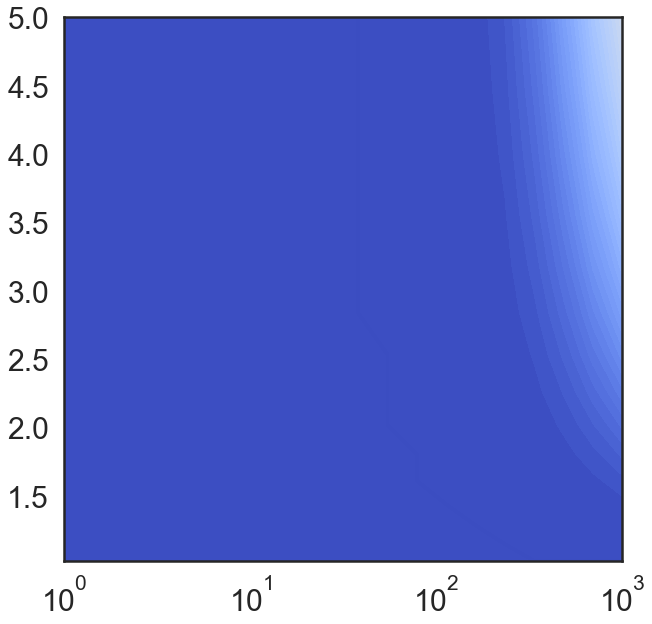

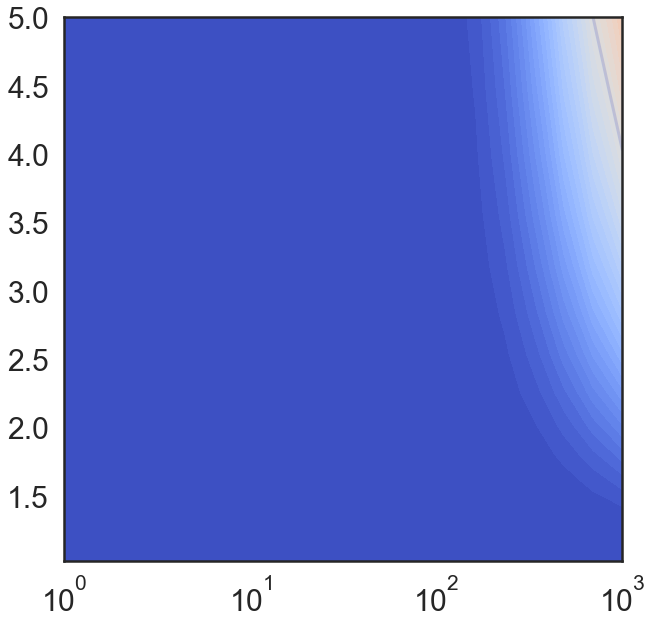

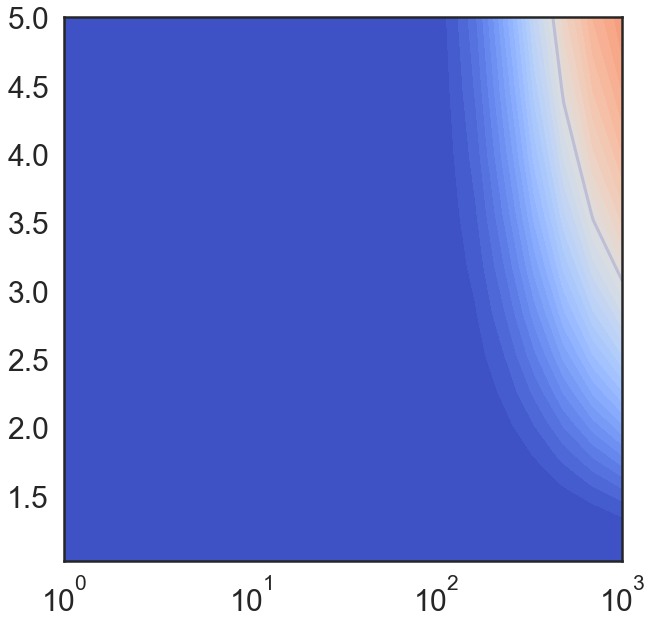

In [16]:

for ix, x_val in enumerate(x_values[:3]):
    print(x_val)
    fig,ax= plt.subplots(1,1, figsize = (10,10))
    #contourrline at 0.5
    ax.contourf( kappa_s_plot,R0s, proba_phase_diag[:,ix,:] ,levels=30, vmax= 1, vmin = 0)
    l  = plt.contour(kappa_s_plot,R0s, proba_phase_diag[:,ix,:], levels = [0.5], alpha = 0.2)
    
    #extract line coordinates
    x,y= l.allsegs[0][0].T
    print(x==kappa_s_plot)
    print(y)
    
    ax.set_xscale('log')

In [18]:
import matplotlib.colors as mcolors
colors_kappa = funcs.color_dict(kappa_s_plot, plt.cm.plasma_r)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


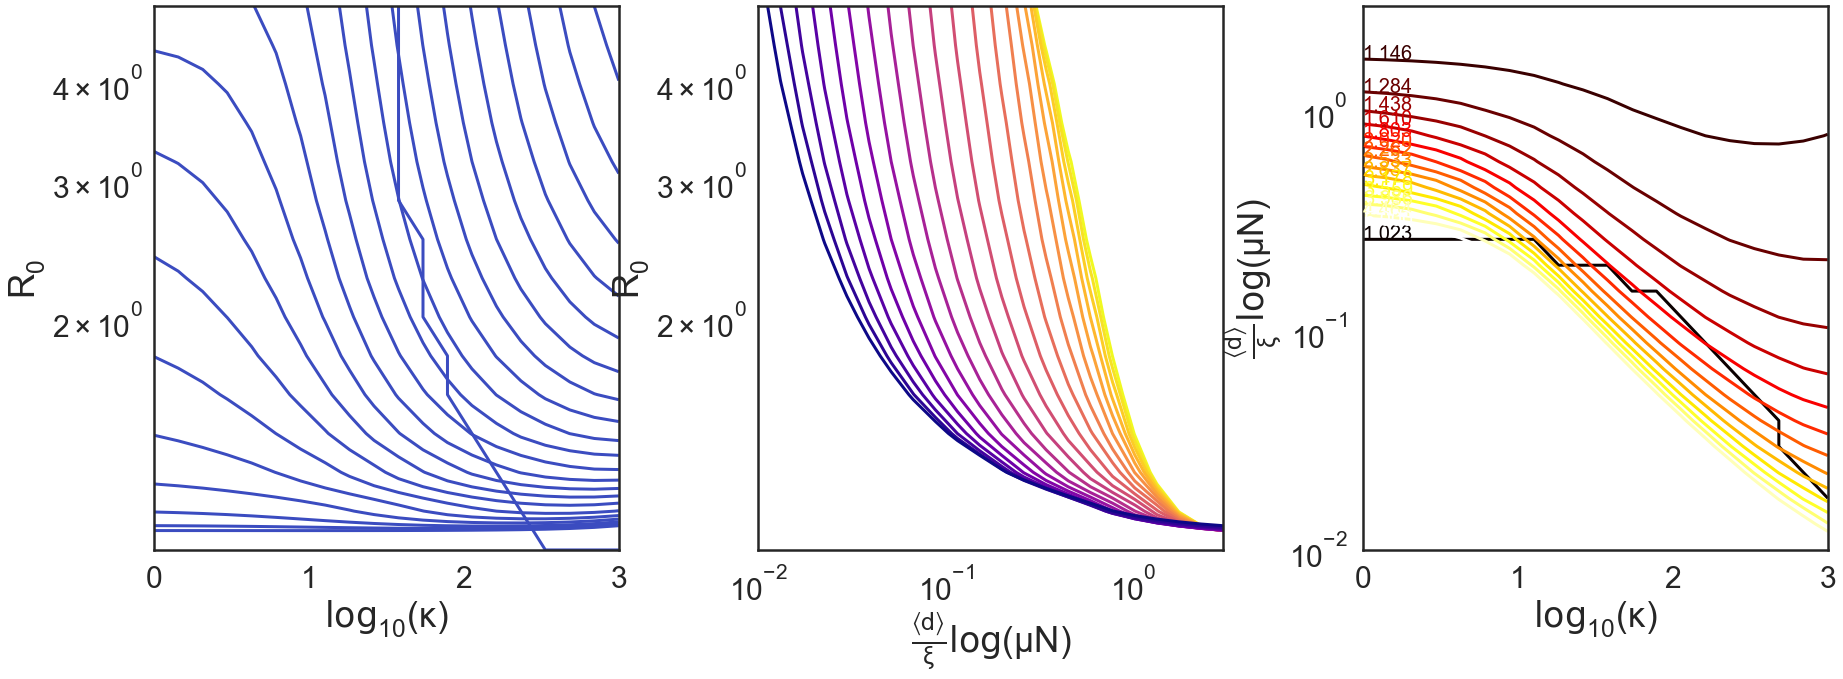

In [61]:
fig,ax = plt.subplots(1,3, figsize = (30,10))

fig.subplots_adjust(wspace=0.3)
for ix in range(len(x_values)):
    l  = ax[0].contour( np.log10(kappa_s_plot), R0s, proba_phase_diag[:,ix,:],'black--', levels = [0.5], alpha = 1., )
# ax[0].contourf( np.log10(kappa_s_plot),R0s, proba_phase_diag[:,0,:] ,levels=30, vmax= 1, vmin = 0)
ax[0].set_xlabel('$\log_{10}(\kappa)$')
ax[0].set_ylabel('$R_0$')
ax[0].set_yscale('log')

for ik, kappa in enumerate(kappa_s_plot):
    l  = ax[1].contour( x_values, R0s, proba_phase_diag[:,:,ik], levels = [0.5], alpha = 1., colors = mcolors.to_hex(colors_kappa[kappa]))
# ax[1].contourf( x_values,R0s, proba_phase_diag[:,:,0] ,levels=30, vmax= 1, vmin = 0)
ax[1].set_ylabel('$R_0$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\frac{\langle d \rangle}{\xi} \log(\mu N)$')

colors_R0 = funcs.color_dict(R0s, plt.cm.hot)

for ir ,R0 in enumerate(R0s[:]):
    
    l  = ax[-1].contour( np.log10(kappa_s_plot), x_values, proba_phase_diag[ir,:,:], levels = [0.5], alpha = 1., colors= mcolors.to_hex(colors_R0[R0]))
    lx,ly = l.allsegs[0][0].T

    ax[-1].annotate(f'{R0:.3f}', (lx[0],ly[0]), color = mcolors.to_hex(colors_R0[R0]), fontsize = 20)
ax[-1].set_xlabel('$\log_{10}(\kappa)$')
ax[-1].set_ylabel(r'$\frac{\langle d \rangle}{\xi} \log(\mu N)$')
ax[-1].set_yscale('log')

handles = [ 
    Line2D([0], [0], color=colors_R0[R0], lw=4) for R0 in R0s[::2]
]
labels = [f'$R_0={R0:.3f}$' for R0 in R0s[::2]]



# ax[-1].legend(handles,labels,loc = 'best')

In [52]:
R0s

array([1.02329299, 1.14607264, 1.28358397, 1.43759459, 1.61008414,
       1.80326983, 2.01963486, 2.26196042, 2.53336138, 2.83732633,
       3.17776247, 3.55904578, 3.98607731, 4.46434615, 5.        ])

In [53]:
from matplotlib.collections import LineCollection

def rainbowarrow(ax, start, end, cmap="viridis", n=50,lw=3):
    cmap = plt.get_cmap(cmap,n,)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = np.array([x,y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0,1,n))
    ax.add_collection(lc)
    # Arrow head: Triangle
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = np.arctan2(end[1]-start[1],end[0]-start[0])
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(end[0],end[1], c=1, s=(2*lw)**2, marker=tri, cmap=cmap,vmin=0)
    ax.autoscale_view()

In [54]:
#kappa_crit = -(R0*\[Mu]N*ProductLog(-((E**(1 - 1/R0)*R0)/((-1 + R0)*\[Mu]N))))
kappa_crit = lambda R0,mu,N: -(R0*mu*N*np.real(sps.lambertw(-((np.exp(1 - 1/R0)*R0)/((-1 + R0)*mu*N)))))


In [55]:
kappa_crits = kappa_crit(R0s,mu,N)

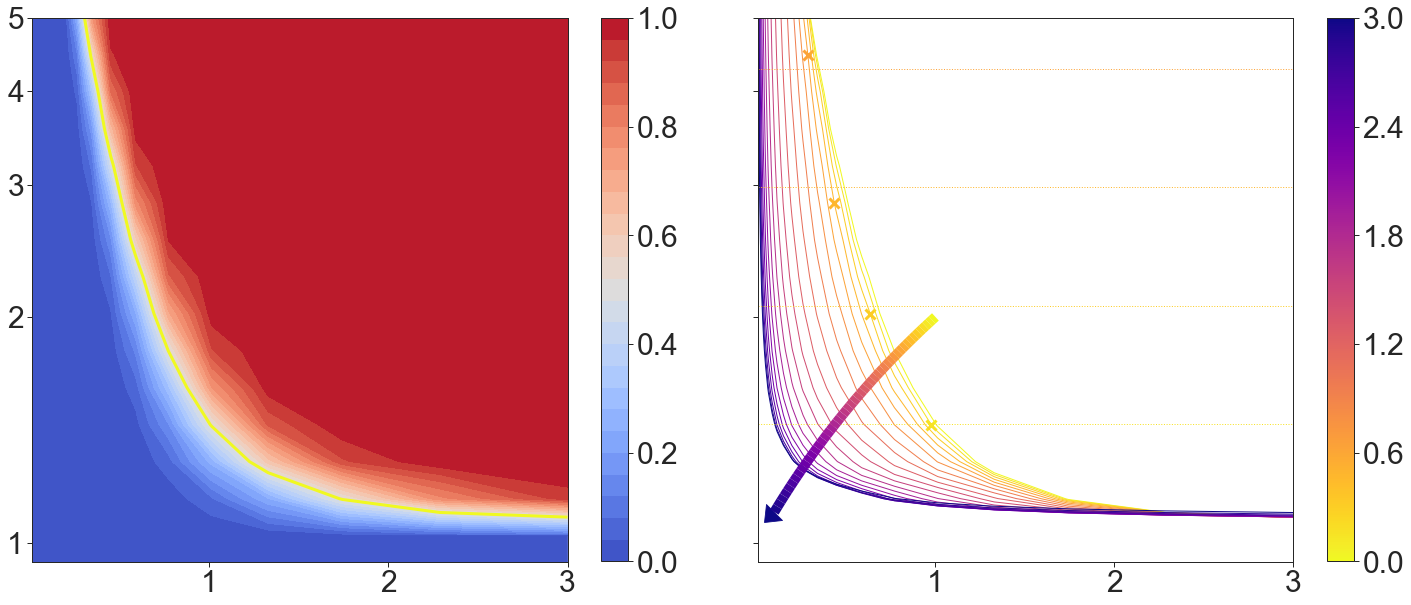

In [318]:
avg_d = 1/p_alpha

fig,ax =plt.subplots(1,2, figsize=(25,10),sharey= True)
plt.subplots_adjust(wspace=0.085)
ik = 0
cplot =ax[0].contourf( x_values, R0s, proba_phase_diag[:,:,ik], levels = 30, alpha = 1., vmin = 0, vmax = 1)
l = ax[0].contour( x_values, R0s, proba_phase_diag[:,:,ik], levels = [0.5], alpha = 1., colors = mcolors.to_hex(colors_kappa[kappa_s_plot[ik]]))
#colorbar besides ax[0], with min  0 and max 1
cbar = fig.colorbar(cplot, ax=ax[0], ticks=np.linspace(0,1,6), shrink=1)

# ax[0].fill_between(np.linspace(0,2,200), 0, 5, where= np.linspace(0,2,200) < 0.3, facecolor='grey', alpha=0.5)
df_contour_lines = pd.DataFrame(columns = ['x','y'])
for ik, kappa in enumerate(kappa_s_plot):
    l  = ax[1].contour( x_values, R0s, proba_phase_diag[:,:,ik], levels = [0.5], alpha = 0, colors = mcolors.to_hex(colors_kappa[kappa]))
    lx, ly = l.allsegs[0][0].T
    
    #lx = avg_d/xi_s *np.log(mu*N)
    xi_lx = avg_d/lx *np.log(mu*N)
    lx_rescaled = avg_d/xi_lx *np.log(mu*N) - avg_d/xi_lx*np.log(kappa)

    ax[1].plot(lx,ly, color = mcolors.to_hex(colors_kappa[kappa]), lw=1)
    # ax[1].scatter
    # ax[1].plot(lx_rescaled,ly, color = mcolors.to_hex(colors_kappa[kappa]), linestyle='--', lw=1)
    # df_contour_lines = df_contour_lines.append(pd.DataFrame({'x':lx, 'y':ly, 'kappa':kappa}))

ylim1 = ax[1].get_ylim()
for ik, kappa in enumerate(kappa_s_plot):
    l  = ax[1].contour( x_values, R0s, proba_phase_diag[:,:,ik], levels = [0.5], alpha = 0, colors = mcolors.to_hex(colors_kappa[kappa]))
    lx, ly = l.allsegs[0][0].T
    if kappa< ylim1[1] and kappa>ylim1[0]:
        ax[1].axhline(kappa, color = mcolors.to_hex(colors_kappa[kappa]), lw=1, linestyle=':')
        ind_ly_eq_kappa = np.argmin(np.abs(ly-(kappa)))
        ax[1].scatter(lx[ind_ly_eq_kappa],ly[ind_ly_eq_kappa], color = mcolors.to_hex(colors_kappa[kappa]), s=100, marker='x')


# ax[1].contourf( x_values,R0s, proba_phase_diag[:,:,0] ,levels=30, vmax= 1, vmin = 0)
# for a in ax:
#     # a.set_yscale('log')
#     # a.set_xscale('log')
#     a.set_xlim(0,3)
#     a.set_ylim(1,5)
    # a.set_xlabel(r'$\frac{\langle d \rangle}{\xi} \log(\mu N)$, mutation strength')
# ax[1].annotate(r'$\kappa$, epidemic control', xy=(1, 2), xycoords='data', fontsize=30)
rainbowarrow(ax[1], (1,2), (0.1,1.1), cmap="plasma_r", n=50,lw=10)
# ax[0].set_ylabel('$R_0$, contact rate')
#colorbar besides ax[1] with values of kappa and colors  from colors_kappa
cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=np.log10(kappa_s_plot[0]), vmax=np.log10(kappa_s_plot[-1])), cmap=plt.cm.plasma_r), ax=ax[1], ticks=np.linspace(np.log10(kappa_s_plot[0]), np.log10(kappa_s_plot[-1]),6), shrink=1)
#set colorbbar label
# cbar2.set_label(r'$\log_{10}(\kappa)$, epidemic control', rotation=270, labelpad=30, fontsize=30)

# ax[1].plot(mu*N/(2*R0s),R0s, 'k--', lw=3)
# ax[1].set_xscale('log')
ax[1].set_yscale('log')

# ax[0].set_xscale('log')
# ax[1].set_xlim(1e-4,2)
# ax[1].set_xlim(1e-3,2)

#set ticks of ax0
ax[0].set_yticks(np.linspace(1,5,5))
import matplotlib.ticker as mticker

ax[0].yaxis.set_major_formatter(mticker.ScalarFormatter())
ax[0].ticklabel_format(axis="y", style='plain')

#color of coolwarm_0
color= plt.cm.coolwarm(5)
#fill horizontal strip from 0 to 1 in ax[0] with color
ax[0].fill_between(np.linspace(0.01,5,10000), 0, R0s[0], where= np.linspace(0.01,5,10000) <= 3.0, facecolor=color, edgecolor= color, alpha=1)

for a in ax:
    a.tick_params(axis='y', direction='out')






# plt.savefig('fig2.pdf',bbox_inches='tight')


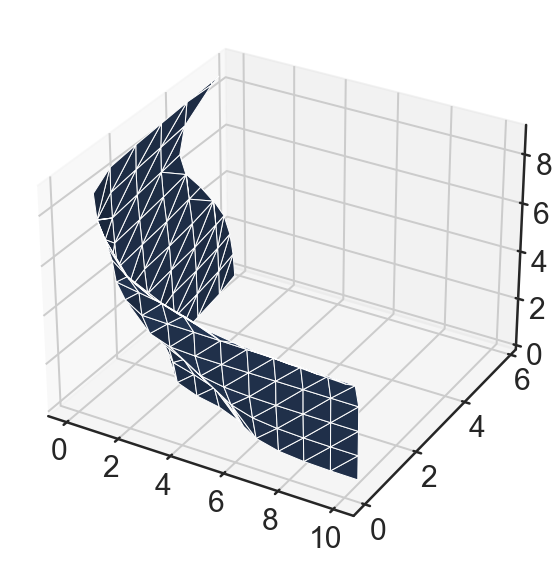

In [ ]:
# #import marching cubes
# from skimage import measure
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# #extract surface at 0.5 level
# verts, faces, _, _ = measure.marching_cubes(proba_phase_diag[:,:,:], 0.5)

# #plot surface
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection= '3d')
# ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1)
# # ax.set_xlabel('log kappa')
# # ax.set_ylabel('R0')
# # ax.set_zlabel('xi')



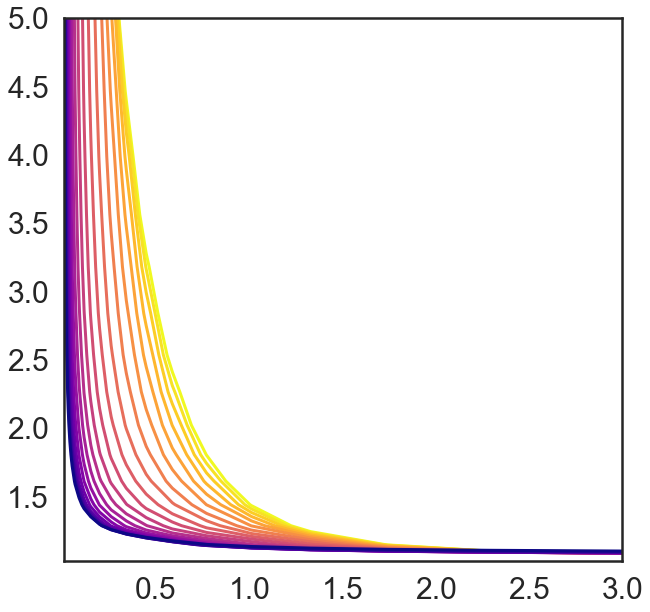

In [ ]:
fig,ax= plt.subplots(figsize=(10,10))
for ik, kappa in enumerate(kappa_s_plot):
    l  = ax.contour( x_values, R0s, proba_phase_diag[:,:,ik], levels = [0.5], alpha = 1., colors = mcolors.to_hex(colors_kappa[kappa]))



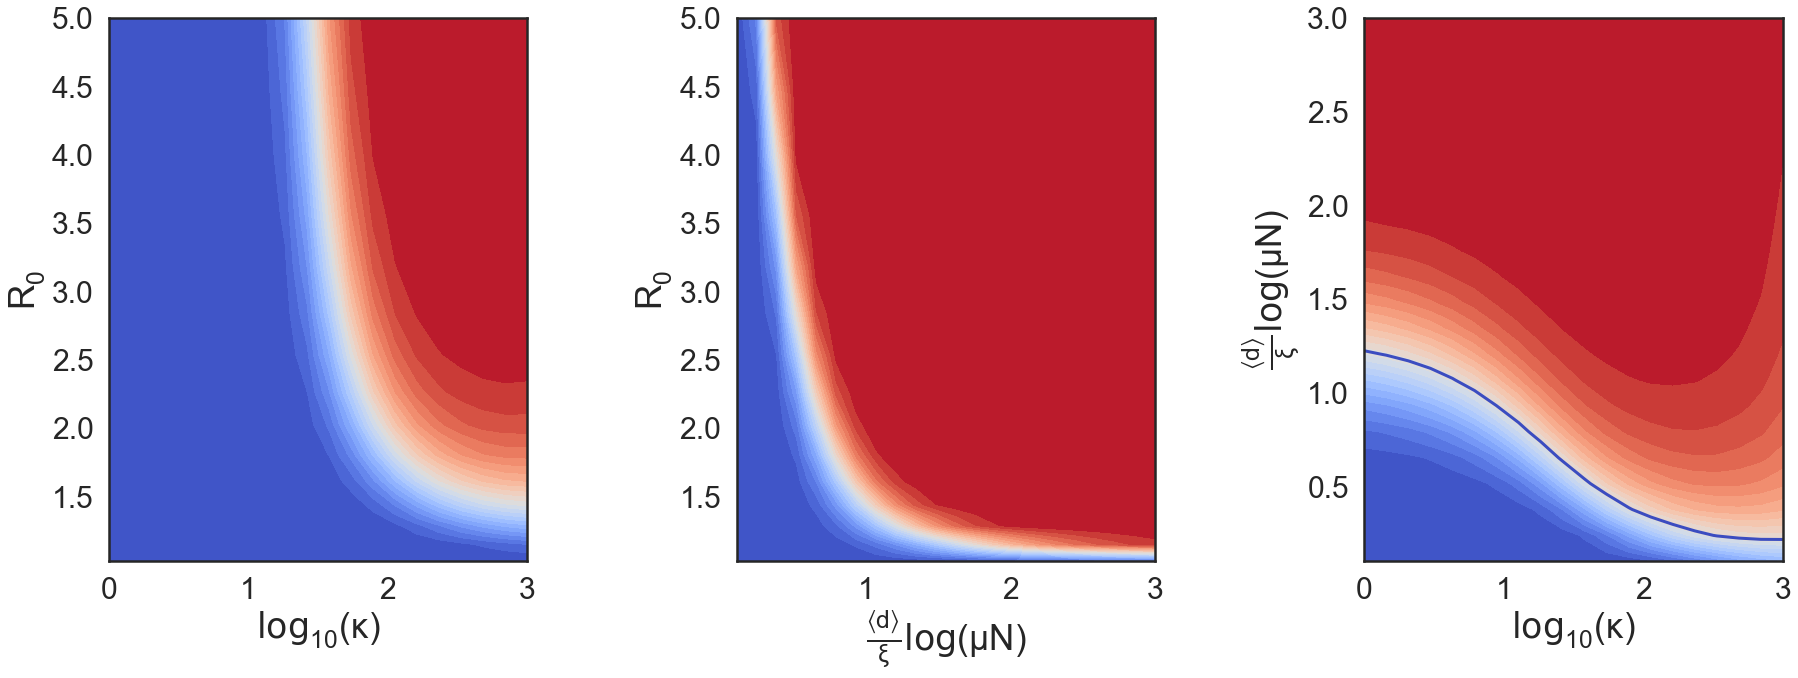

In [ ]:
#import marching cubes
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#extract surface at 0.5 level
verts, faces, _, _ = measure.marching_cubes( proba_phase_diag[:,:,:], 0.5)
import plotly.figure_factory as ff

fig,ax = plt.subplots(1,3, figsize = (30,10))
plt.subplots_adjust(wspace = 0.5)
ax[0].contourf( np.log10(kappa_s_plot),R0s, proba_phase_diag[:,0,:] ,levels=30, vmax= 1, vmin = 0)
ax[0].set_xlabel('$\log_{10}(\kappa)$')
ax[0].set_ylabel('$R_0$')


ax[1].contourf( x_values,R0s, proba_phase_diag[:,:,0] ,levels=30, vmax= 1, vmin = 0)
ax[1].set_ylabel('$R_0$')
ax[1].set_xlabel(r'$\frac{\langle d \rangle}{\xi} \log(\mu N)$')


ax[-1].contourf( np.log10(kappa_s_plot), x_values, proba_phase_diag[2,:,:] ,levels=30, vmax= 1, vmin = 0)
l  = ax[-1].contour( np.log10(kappa_s_plot), x_values, proba_phase_diag[2,:,:],'black--', levels = [0.5], alpha = 1., )
ax[-1].set_xlabel('$\log_{10}(\kappa)$')
ax[-1].set_ylabel(r'$\frac{\langle d \rangle}{\xi} \log(\mu N)$')


x_max= np.array((R0s.max(), x_values.max(), np.log10(kappa_s_plot.max())))
x_min= np.array((R0s.min(), x_values.min(), np.log10(kappa_s_plot.min())))

verts_actual = verts*((x_max-x_min)/proba_phase_diag.shape) + x_min
fig = ff.create_trisurf(
    x=verts_actual[:, 0], y=verts_actual[:, 1], z=verts_actual[:, 2], simplices=faces, title="", aspectratio=dict(x=1, y=1, z=1), show_colorbar=False,
)

#set xticks to values of R0
fig.update_layout(scene = dict(
                    xaxis_title=r'R0 (x)',
                    yaxis_title=r'mutation strength (y)',
                    zaxis_title=r'log epidemic control (z)'),
                    xaxis = dict(
                        # tickmode = 'array',
                        tickvals = [0,2,5],
                        ticktext = ['One', 'Three', 'Five'])
)

# fig.update_layout(
#     scene = dict(
#         xaxis = dict(nticks=4, range=[0,10],),
#         yaxis = dict(nticks=4, range=[0,10],),
#         zaxis = dict(nticks=4, range=[0,10],),),
#     width=700,
#     margin=dict(r=20, l=10, b=10, t=10))
fig.show()


In [ ]:
verts[:,0].min()
verts[:,0].max()



10.0

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Surface(z=x_values[ix]*np.ones((len(R0s), len(kappa_s))) , x=R0s, y=np.log10(kappa_s_plot), opacity=0.7, surfacecolor= proba_phase_diag[:,ix,:], colorscale='Viridis_r', colorbar=dict(title='Probability of evolution')) for ix in range(len(x_values))],
)

fig.show()
    

In [ ]:
!pip install scikit-image==0.20.1

ERROR: Ignored the following versions that require a different python version: 0.20.0 Requires-Python >=3.8; 0.20.0rc2 Requires-Python >=3.8; 0.20.0rc3 Requires-Python >=3.8; 0.20.0rc4 Requires-Python >=3.8; 0.20.0rc5 Requires-Python >=3.8; 0.20.0rc6 Requires-Python >=3.8; 0.20.0rc7 Requires-Python >=3.8; 0.20.0rc8 Requires-Python >=3.8; 0.21.0 Requires-Python >=3.8; 0.21.0rc0 Requires-Python >=3.8; 0.21.0rc1 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement scikit-image==0.20.1 (from versions: 0.7.2, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.9.3, 0.10.0, 0.10.1, 0.11.2, 0.11.3, 0.12.0, 0.12.1, 0.12.2, 0.12.3, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.14.2, 0.14.3, 0.14.4, 0.14.5, 0.15.0, 0.16.1, 0.16.2, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.18.2, 0.18.3, 0.19.0rc0, 0.19.0, 0.19.1, 0.19.2, 0.19.3)
ERROR: No matching distribution found for scikit-image==0.20.1


In [ ]:
xi = 20

p_d = lambda p_alpha,d : p_alpha*(1-p_alpha)**(d-1)

p_exp_d = lambda d_alpha,d : np.exp(-(d -1)/d_alpha) /d_alpha

p_alpha = .5
d_alpha= - 1/np.log(1-p_alpha)
N =1e7

In [ ]:
np.log10(np.exp(80))

34.74355855226015

In [ ]:

%%time
ds= np.arange(1,20)
R0s_pd = np.linspace(1.01,5, 50)
mu=1e-4
xi = 20

E = exp_num_R0_k_phase_diagram(R0s_pd,kappas,xi,ds,)


R0_kappa_phase_diag = mu*E.R0_kappa_phase_diag
R0_kappa_proba_phase_diag = 1- np.exp(-R0_kappa_phase_diag)

Object exists already, loading it
CPU times: user 2.43 ms, sys: 2.82 ms, total: 5.25 ms
Wall time: 13.3 ms


In [ ]:
mu=1e-4
R0s_pd_u = np.linspace(1.01,5, 50)

x_values = np.linspace(0.1, 3, 100)
xis_pd_u= (1/p_alpha) *np.log(mu*N)/x_values
x1 = -1/(np.log(1-p_alpha)*xis_pd_u)*np.log(N*mu)
ds = np.arange(1,int(10/p_alpha))
U = exp_num_R0_xi_phase_diagram_unperturbed(R0s_pd_u,xis_pd_u,ds, dt=1., to_end_flag=1)

50it [13:25, 16.10s/it]

Pickling data
saving /Users/dtrimcev/Dropbox/Work_Main/to_be_transition_project/analysis/phase_diagram_pictures/pickles/R0s-(1.01-5.0)_xi_s-(4.605170185988091-138.15510557964274)_kappa-None_N-10000000.0_dt-1.0_to_end_flag-1_unperturbed_phase_diagram.pkl


In [ ]:
x_values = np.linspace(0.1, 3, 100)
xis_pd_u= (1/p_alpha) *np.log(mu*N)/x_values
x1 = -1/(np.log(1-p_alpha)*xis_pd_u)*np.log(N*mu)

In [ ]:
R0_xi_phase_diag_u = mu*U.R0_xi_phase_diag
R0_xi_proba_phase_diag_u = 1- np.exp(-R0_xi_phase_diag_u)

U.R0_xi_phase_diag.shape

x1 = -1/(np.log(1-p_alpha)*xis_pd_u)*np.log(N*mu)
x2 = R0s_pd_u


In [ ]:
def eqn_R0_k_full(R0,k, muN,p, xi):
    xi_d = -1/np.log(1-p)
    return np.abs(  np.log(R0*(1-x_inf_func(R0,k))/(R0-1)) - xi_d/xi *np.log(muN*(1-x_inf_func(R0,k))/(1-p))  )


def eqn_R0_k(R0,k, muN,p, xi):
    xi_d = -1/np.log(1-p)
    x_inf = (1-R0/k)/R0
    return np.abs(  np.log(R0*(1-x_inf)/(R0-1)) - xi_d/xi *np.log(muN*(1-x_inf)))

In [ ]:
import scipy.special as sps

In [ ]:
def eqn_R0_star_full(R0, muN,p, xi):
    xi_d = -1/np.log(1-p)
    return np.abs(  np.log(R0*rInf(R0)/(R0-1)) - xi_d/xi *np.log(muN*rInf(R0)/((1-p))*(R0-1))  )

def eqn_R0_k_full(R0,k, muN,p, xi):
    xi_d = -1/np.log(1-p)
    return np.abs(  np.log(R0*(1-x_inf_func(R0,k))/(R0-1)) - xi_d/xi *np.log(muN*(1-x_inf_func(R0,k))/((1-p))*(R0-1))  )

def eqn_R0_k(R0,k, muN,p, xi):
    xi_d = -1/np.log(1-p)
    x_inf = (1-R0/k)/R0
    return np.abs(  np.log(R0*(1-x_inf)/(R0-1)) - xi_d/xi *np.log(muN*(1-x_inf)/((1-p))*(R0-1))  )

def eqn_R0_star(R0, muN,p, xi):
    xi_d = -1/np.log(1-p)
    return np.abs(  np.log(R0* (1-np.exp(-R0))/(R0-1)) - xi_d/xi *np.log(muN*(1-np.exp(-R0))/((1-p))*(R0-1))  )

In [ ]:
rInf= lambda R0: 1 + np.real(sps.lambertw(-R0*np.exp(-R0))/R0)
rP  = lambda R0: np.log(R0)/R0

In [ ]:
xInf = lambda R0: 1 - rInf(R0)

In [ ]:
p_alpha= .5
sols_mu = []
sols_mu_exp = []
mu=1e-4

for xi_t in xis_pd_u:
    #print(-1/(np.log(1-p)*xi))
    sol,arg, suc,msg= so.fsolve(eqn_R0_star_full,1.01, args=(mu*N,p_alpha,xi_t),full_output=1)
    if suc==1:
        #print(p,sol,suc, msg)
        sols_mu.append(sol[0])
    else: 
        sols_mu.append(1)
    
    sol,arg, suc,msg= so.fsolve(eqn_R0_star,1.01, args=(mu*N,p_alpha,xi_t),full_output=1)
    if suc==1:
        #print(p,sol,suc, msg)
        sols_mu_exp.append(sol[0])
    else: 
        sols_mu_exp.append(1)


In [ ]:
def x_inf_func(R0, k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return -1/R0*sps.lambertw(-R0*np.exp(-R0))

In [ ]:
p_alpha= .5
mu = 1e-4
sols_kappa = []
sols_kappa_easy = []


for kappa in kappas:
    #print(-1/(np.log(1-p)*xi))
    sol,arg, suc,msg= so.fsolve(eqn_R0_k_full,1.01, args=(kappa,mu*N,p_alpha,xi),full_output=1)
    if suc==1:
        #print(p,sol,suc, msg)
        sols_kappa.append(sol[0])
    else: 
        sols_kappa.append(1)
    
    sol,arg, suc,msg= so.fsolve(eqn_R0_k,1.01, args=(kappa,mu*N,p_alpha,xi),full_output=1)
    if suc==1:
        #print(p,sol,suc, msg)
        sols_kappa_easy.append(sol[0])
    else: 
        sols_kappa_easy.append(1)

Text(0.5, 0, '$\\kappa$ (epidemiological control)')

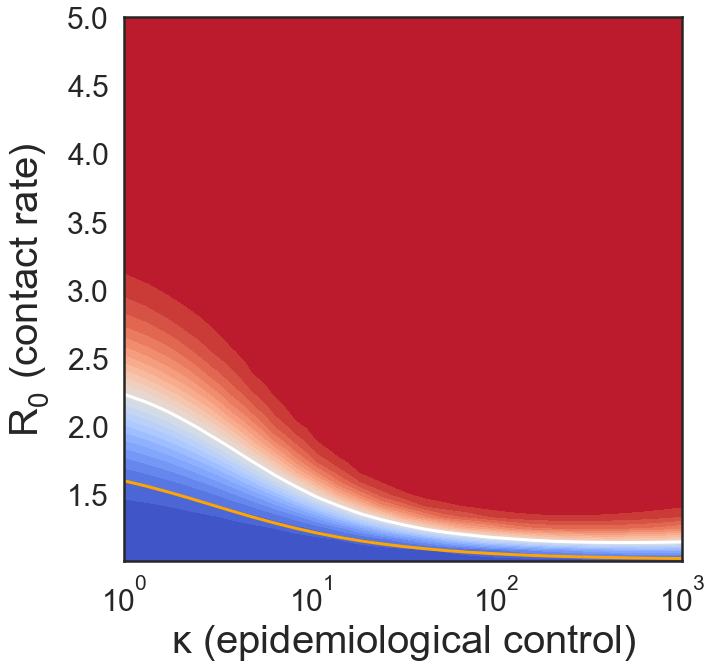

In [ ]:
fig, ax= plt.subplots(figsize=(10,10))

ax.contourf( kappas,R0s_pd,R0_kappa_proba_phase_diag ,levels=30, vmax= 1, vmin = 0)
x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.plot(kappas,sols_kappa, color='orange')
#ax.plot(kappas,sols_kappa_easy, color='orange')
critline = ax.contour( kappas,R0s_pd,R0_kappa_proba_phase_diag ,levels=[.5], colors='white',alpha=1)#, vmax= V, vmin = -V)
#ax.plot(k_small_test(R0s_pd[1:],mu*N,p_alpha,xi),R0s_pd[1:],color='lime',linestyle='--')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel(r'$R_0$ (contact rate)',labelpad= 15,fontsize=40)

ax.set_xlabel(r'$\kappa$ (epidemiological control)',fontsize=40)

In [ ]:
R0_xi_phase_diag_u = mu*U.R0_xi_phase_diag
R0_xi_proba_phase_diag_u = 1- np.exp(-R0_xi_phase_diag_u)

U.R0_xi_phase_diag.shape

x1 = -1/(np.log(1-p_alpha)*xis_pd_u)*np.log(N*mu)
x2 = R0s_pd_u


In [ ]:
xis_pd_u

array([138.15510558, 106.85433947,  87.11691371,  73.5341691 ,
        63.61560676,  56.05473546,  50.10020312,  45.28925646,
        41.32131557,  37.99265403,  35.16029679,  32.72094606,
        30.59811063,  28.73394003,  27.08387218,  25.61302519,
        24.29370418,  23.10364097,  22.02472698,  21.04208531,
        20.14338064,  19.31829866,  18.55814851,  17.85555542,
        17.20422069,  16.59873235,  16.03441436,  15.50720573,
        15.01356252,  14.55037814,  14.11491791,  13.70476498,
        13.31777551,  12.95204115,  12.60585756,  12.27769789,
        11.96619025,  11.67009851,  11.38830596,  11.11980118,
        10.86366597,  10.61906479,  10.38523573,  10.16148251,
         9.9471676 ,   9.74170616,   9.54456068,   9.35523629,
         9.17327663,   8.99826017,   8.82979694,   8.66752564,
         8.51111105,   8.36024172,   8.2146279 ,   8.07399968,
         7.93810531,   7.80670973,   7.67959318,   7.55654997,
         7.43738741,   7.32192476,   7.20999233,   7.10

(0.0, 2.1640425613334453)

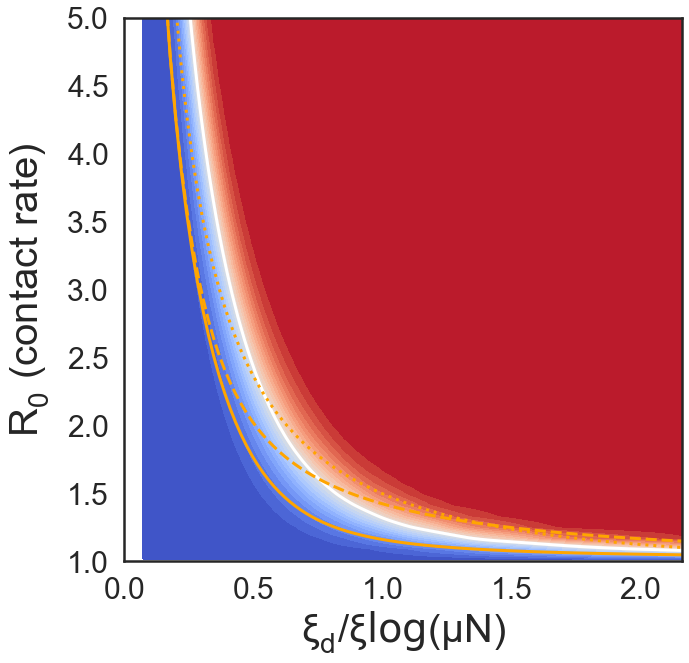

In [ ]:
x2 = R0s_pd_u

fig, ax= plt.subplots(figsize=(10,10))
ax.contourf( x1,x2,R0_xi_proba_phase_diag_u ,levels=30, vmax= 1, vmin = 0)
critline = plt.contour( x1,x2,R0_xi_proba_phase_diag_u  ,levels=[.5], colors='white',alpha=1)#, vmax= V, vmin = -V)

#plt.plot(x1,p_sols_xi[p_alpha],color='white');

xi_d = -1/np.log(1-p_alpha)


c, = plt.plot(xi_d/xis_pd_u *np.log(N*mu), sols_mu,color='orange')
ax.plot(xi_d/xis_pd_u *np.log(N*mu), sols_mu_exp, color= c.get_color(),linestyle='--')
ax.plot(xi_d/xis_pd_u *np.log(N*mu), 1/(1- np.power(mu*N/(1-p_alpha),-xi_d/xis_pd_u)), color = c.get_color(),linestyle=':')

#plt.xscale('log')
#ax.set_yscale('log')
ax.set_ylim(bottom=1.,top=5)

ax.set_ylabel(r'$R_0$ (contact rate)',labelpad= 15,fontsize=40)
ax.set_xlabel(r'$\xi_d/\xi \log(\mu N)$',fontsize=40)
ax.set_xlim(left=0)
#ax.set_xscale('log')

In [ ]:
mu

0.0001

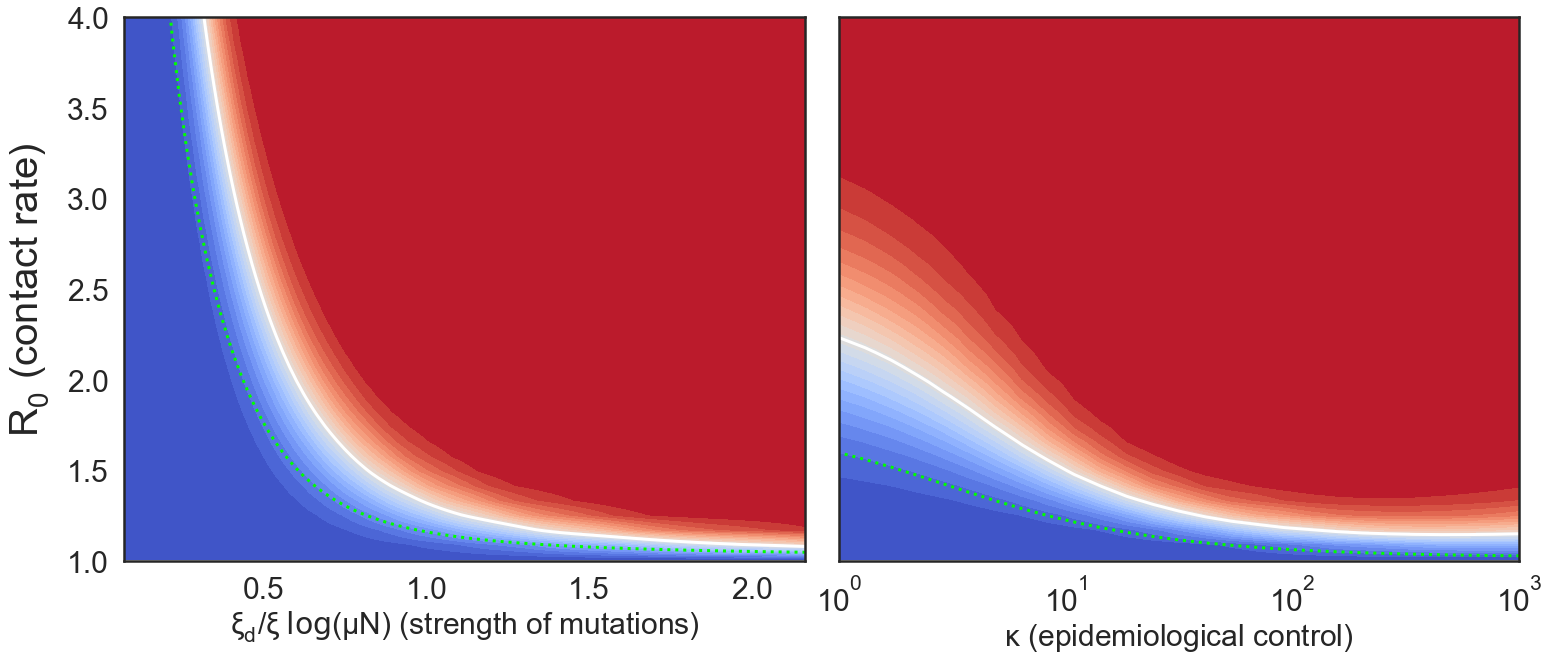

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(25,10),sharey=True)
plt.subplots_adjust(wspace=.05)
ax[0].contourf( x1,x2,R0_xi_proba_phase_diag_u ,levels=30, vmax= 1, vmin = 0)
critline = ax[0].contour( x1,x2,R0_xi_proba_phase_diag_u  ,levels=[.5], colors='white',alpha=1)#, vmax= V, vmin = -V)

#plt.plot(x1,p_sols_xi[p_alpha],color='white');

xi_d = -1/np.log(1-p_alpha)


c, = ax[0].plot(xi_d/xis_pd_u *np.log(N*mu), sols_mu,color='lime',linestyle=':')
# ax[0].plot(xi_d/xis_pd_u *np.log(N*mu), sols_mu_exp, color= c.get_color(),linestyle='--')
# ax[0].plot(xi_d/xis_pd_u *np.log(N*mu), 1/(1- np.power(mu*N/(1-p_alpha),-xi_d/xis_pd_u)), color = c.get_color(),linestyle=':')

#plt.xscale('log')
#ax.set_yscale('log')
ax[0].set_ylim(bottom=1.,top=5)

ax[0].set_ylabel(r'$R_0$ (contact rate)',labelpad= 15,fontsize=40)
ax[0].set_xlabel(r'$\xi_d/\xi \;\log(\mu N)$ (strength of mutations)',fontsize=30)

ax[1].contourf( kappas,R0s_pd,R0_kappa_proba_phase_diag ,levels=30, vmax= 1, vmin = 0)
x_lim, y_lim = ax[1].get_xlim(), ax[1].get_ylim()
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)
ax[1].plot(kappas,sols_kappa, color='lime',linestyle=':')
#ax.plot(kappas,sols_kappa_easy, color='orange')
critline = ax[1].contour( kappas,R0s_pd,R0_kappa_proba_phase_diag ,levels=[.5], colors='white',alpha=1)#, vmax= V, vmin = -V)
#ax.plot(k_small_test(R0s_pd[1:],mu*N,p_alpha,xi),R0s_pd[1:],color='lime',linestyle='--')
ax[1].set_xscale('log')
#ax.set_yscale('log')
#ax[1].set_ylabel(r'$R_0$ (contact rate)',labelpad= 15,fontsize=40)
ax[1].set_ylim((1,4))
ax[1].set_xlabel(r'$\kappa$ (epidemiological control)',fontsize=30)

plt.savefig('fig2.pdf',bbox_inches='tight')

6.88091092351321

1.5 1000.0
2 10


In [ ]:
import plotly.graph_objects as go
import numpy as np

z1 = np.array([
    [8.83,8.89,8.81,8.87,8.9,8.87],
    [8.89,8.94,8.85,8.94,8.96,8.92],
    [8.84,8.9,8.82,8.92,8.93,8.91],
    [8.79,8.85,8.79,8.9,8.94,8.92],
    [8.79,8.88,8.81,8.9,8.95,8.92],
    [8.8,8.82,8.78,8.91,8.94,8.92],
    [8.75,8.78,8.77,8.91,8.95,8.92],
    [8.8,8.8,8.77,8.91,8.95,8.94],
    [8.74,8.81,8.76,8.93,8.98,8.99],
    [8.89,8.99,8.92,9.1,9.13,9.11],
    [8.97,8.97,8.91,9.09,9.11,9.11],
    [9.04,9.08,9.05,9.25,9.28,9.27],
    [9,9.01,9,9.2,9.23,9.2],
    [8.99,8.99,8.98,9.18,9.2,9.19],
    [8.93,8.97,8.97,9.18,9.2,9.18]
])

z2 = z1 + 1
z3 = z1 - 1

fig = go.Figure(data=[
    go.Surface(z=np.round(z1), surfacecolor= z1 ),
    go.Surface(z=np.round(z2), surfacecolor= z2, showscale=False, opacity=0.9),
    go.Surface(z=np.round(z3), surfacecolor= z3, showscale=False, opacity=0.9)

])

ffig.show()

In [90]:
#est_to_zp = (-1 + R0)*zp**2*(-1 + R0*Log(R0/(-1 + R0)))
#est_to_zp = lambda R0,zp: (-1 + R0)*zp**2*(-1 + R0*np.log(R0/(-1 + R0)))
est_to_zp = lambda R0,zp: (-1 + R0)*zp*np.log(R0/(R0-1))

In [ ]:
est_to_zp()

TypeError: <lambda>() missing 2 required positional arguments: 'R0' and 'zp'

In [96]:
%load_ext autoreload

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


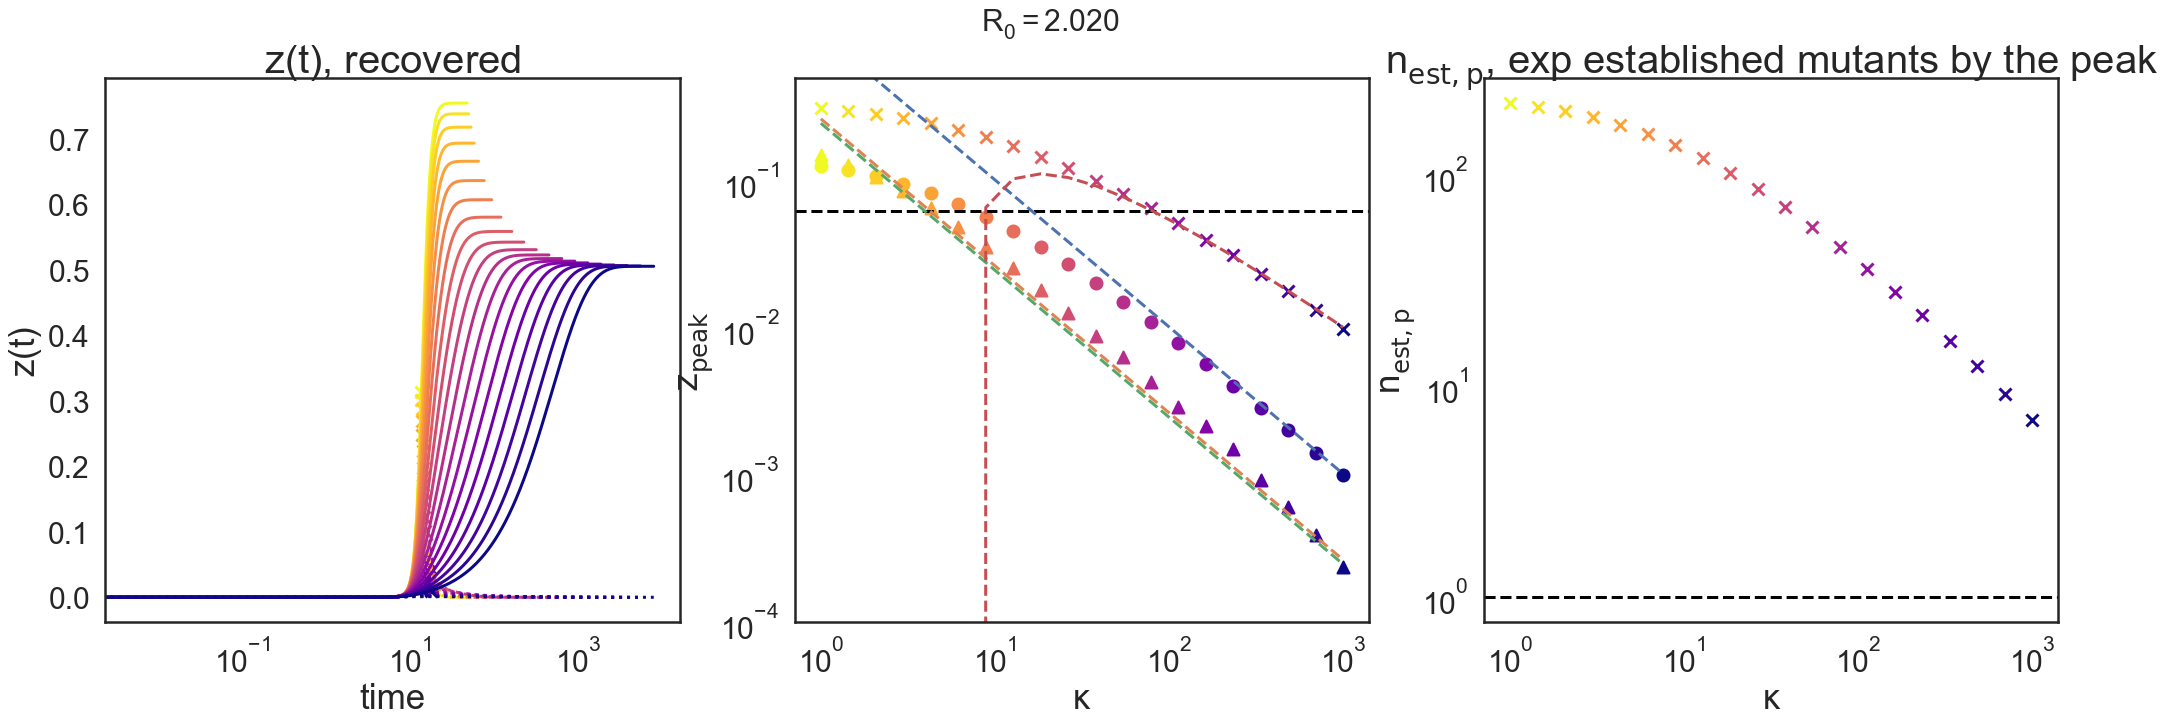

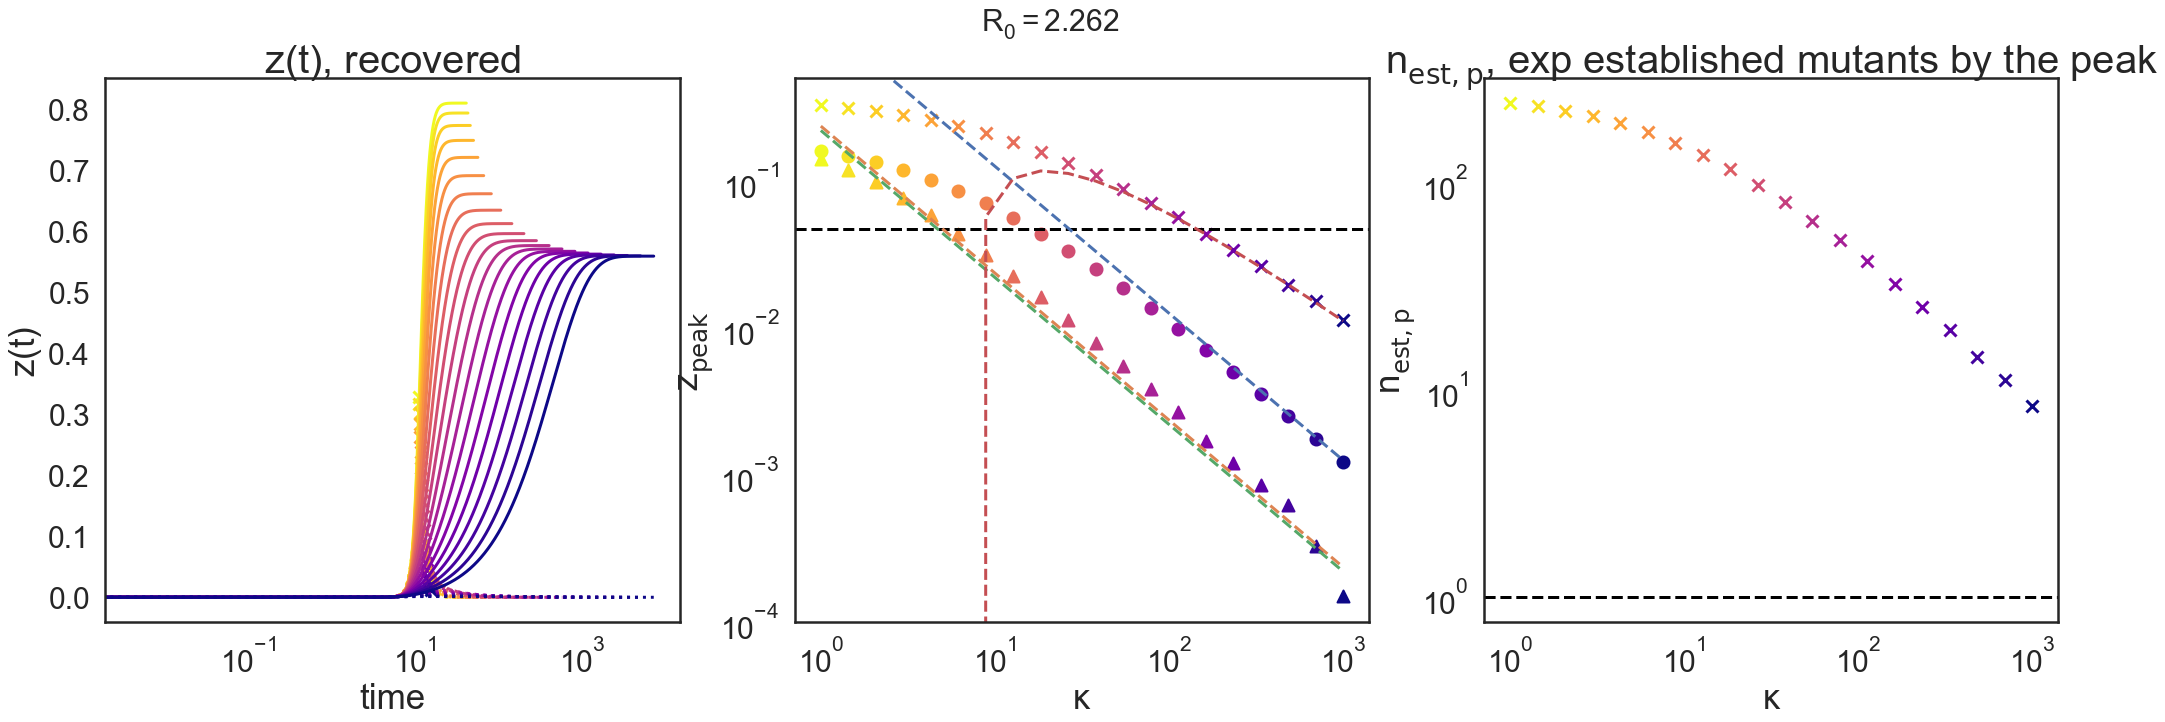

In [240]:
%autoreload
for R0 in R0s[6:8]:
    fig,ax= plt.subplots(1,3,figsize=(35,10))

    y0 = (1-10/N, 10/N,0)
    ts_0 = np.linspace(0,funcs.T_ext_deterministic(R0,0,N),10000)
    x_0,y_0,z_0= odeint(funcs.model, args= (R0,0), t = ts0, y0 = y0).T
    tp_0,zp_0 = ts_0[np.argmax(y_0)],z_0[np.argmax(y_0)]
    yp_0 = y_0[np.argmax(y_0)]

    for kappa in kappa_s_plot:
        ts=np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
        x,y,z= odeint(funcs.model, args= (R0,kappa), t = ts, y0 = y0).T
        tp,zp = ts[np.argmax(y)],z[np.argmax(y)]
        yp = y[np.argmax(y)]
        xp =  x[np.argmax(y)]

        fpp_second_eq= lambda x,y: x-(-1 - R0*y - R0*kappa*y**2 + kappa**2*y**2)/(R0*(-1 + 2*kappa*y))
        fpp_second_solution_ind = np.argwhere(np.diff(np.sign(fpp_second_eq(x,y))) != 0).reshape(-1) + 0
        z_second_solution = z[fpp_second_solution_ind]

        ax[0].plot(ts,z,color=colors_kappa[kappa])
        ax[0].plot(ts,y,color=colors_kappa[kappa],linestyle=':')

        ax[1].scatter(kappa,zp,color=colors_kappa[kappa],marker='x')
        ax[1].scatter(kappa,yp,color=colors_kappa[kappa],marker='o')
        ax[1].scatter(kappa,z_second_solution[0],color=colors_kappa[kappa],marker='^')

        ax[0].scatter(tp,zp,color=colors_kappa[kappa],marker='x')
        ax[-1].scatter(kappa,mu*N*est_to_zp(R0,zp),color=colors_kappa[kappa],marker='x')

    z_peaks = np.array([funcs.z_peak(R0,kappa) for kappa in kappa_s_plot])
    #-(ProductLog[-2 E^(-1 - R0) R0]/(2 R0))
    ax[1].axhline(-sps.lambertw(-2*np.exp(-1 - R0)*R0)/(2*R0),color='black',linestyle='--')
    ax[1].plot(kappa_s_plot,(R0-1)/kappa_s_plot,linestyle='--')

    #1/(R0 \[Kappa] + Sqrt[1 - R0 + R0^2] \[Kappa])
    zf = lambda R0,kappa: 1/(R0*kappa + np.sqrt(1 - R0 + R0**2)*kappa)
    ax[1].plot(kappa_s_plot,zf(R0,kappa_s_plot),linestyle='--')
    ax[1].plot(kappa_s_plot,1/(2*R0*kappa_s_plot),linestyle='--')
    
    ax[1].plot(kappa_s_plot,z_peaks,linestyle='--')

    ax[1].set_xlabel('$\kappa$')
    ax[1].set_ylabel('$z_\mathrm{peak}$')
    ax[1].set_xscale('log')
    ax[1].set_ylim(1/10000,.5)
    ax[1].set_yscale('log')

    ax[-1].axhline(1,color='black',linestyle='--')
    ax[0].set_xscale('log')
    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('$z(t)$')
    ax[-1].set_xlabel('$\kappa$')
    ax[-1].set_ylabel('$n_\mathrm{est,p}$')

    fig.suptitle(f'$R_0={R0:.3f}$',fontsize=30)
    ax[0].set_title('$z(t)$, recovered')
    ax[-1].set_title('$n_\mathrm{est,p}$, exp established mutants by the peak')

    

In [250]:
np.real(zv_0(3))

0.18492277142426503

In [352]:
fig,ax =plt.subplots(2,2,figsize=(35,25)) 

ax= ax.flatten()

# 1 + ProductLog(-1,-2*E**(-1 - R0)*R0)/(2.*R0) - (Log(-0.5*ProductLog(-1,-2*E**(-1 - R0)*R0)/R0) + R0*(1 + ProductLog(-1,-2*E**(-1 - R0)*R0)/(2.*R0)))/R0

xv_0 = lambda R0: np.real(-sps.lambertw(-2*np.exp(-1 - R0)*R0,k=-1)/(2*R0))
zv_0 = lambda R0: 1 -xv_0(R0) - (np.log(-0.5*sps.lambertw(-2*np.exp(-1 - R0)*R0,k=-1)/R0) + R0*(1 + sps.lambertw(-2*np.exp(-1 - R0)*R0,k=-1)/(2*R0)))/R0
ax[1].axhline(zv_0(R0),color='steelblue',linestyle='--')
ax[-1].axhline(zv_0(R0),color='steelblue',linestyle='--')
kappa=0
ts=np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
dt = ts[1]-ts[0]
x,y,z= odeint(funcs.model, args= (R0,kappa), t = ts, y0 = y0).T
tp,zp = ts[np.argmax(y)],z[np.argmax(y)]
yp = y[np.argmax(y)]
xp =  x[np.argmax(y)]

f = R0*x[ts<tp]/(1+kappa*y[ts<tp])-1
fp = np.gradient(f,dt)
fpp = np.gradient(fp,dt)
fppp= np.gradient(fpp,dt)
zero_ind_fpp = np.argwhere(np.diff(np.sign(fpp)) != 0).reshape(-1) + 0
zero_ind_fppp = np.argwhere(np.diff(np.sign(fppp)) != 0).reshape(-1) + 0
min_ind_fpp = np.argmin(fpp)


#zeros of third_derivative
#first equation to solve: x=-(((R0 - \[Kappa])*(1 + \[Kappa]*y(t)))/(R0*\[Kappa]))
#second equation to solve: x=(R0 + R0*y(t)*(2*R0 - 5*\[Kappa] + \[Kappa]*y(t)*(-R0 - 3*\[Kappa] + 3*\[Kappa]*(-R0 + \[Kappa])*y(t))) - Sqrt(y(t)*(R0 + R0*\[Kappa]*y(t))**2*(R0 + y(t)*(3*R0**2 - 4*R0*\[Kappa] + 3*\[Kappa]**2 + \[Kappa]*y(t)*(-4*R0**2 + 14*R0*\[Kappa] - 4*\[Kappa]**2 + 3*(R0 - \[Kappa])**2*\[Kappa]*y(t))))))/(R0**2*(1 + 2*\[Kappa]*y(t)*(-4 + 3*\[Kappa]*y(t))))
#third_equation_to_solve:  x=(R0 + R0*y(t)*(2*R0 - 5*\[Kappa] + \[Kappa]*y(t)*(-R0 - 3*\[Kappa] + 3*\[Kappa]*(-R0 + \[Kappa])*y(t))) + Sqrt(y(t)*(R0 + R0*\[Kappa]*y(t))**2*(R0 + y(t)*(3*R0**2 - 4*R0*\[Kappa] + 3*\[Kappa]**2 + \[Kappa]*y(t)*(-4*R0**2 + 14*R0*\[Kappa] - 4*\[Kappa]**2 + 3*(R0 - \[Kappa])**2*\[Kappa]*y(t))))))/(R0**2*(1 + 2*\[Kappa]*y(t)*(-4 + 3*\[Kappa]*y(t)))) 
fppp_first_eq = lambda x,y: x+(((R0 - kappa)*(1 + kappa*y))/(R0*kappa))
fppp_second_eq= lambda x,y: x-(R0 + R0*y*(2*R0 - 5*kappa + kappa*y*(-R0 - 3*kappa + 3*kappa*(-R0 + kappa)*y)) - np.sqrt(y*(R0 + R0*kappa*y)**2*(R0 + y*(3*R0**2 - 4*R0*kappa + 3*kappa**2 + kappa*y*(-4*R0**2 + 14*R0*kappa - 4*kappa**2 + 3*(R0 - kappa)**2*kappa*y)))))/(R0**2*(1 + 2*kappa*y*(-4 + 3*kappa*y)))
fppp_third_eq = lambda x,y: x-(R0 + R0*y*(2*R0 - 5*kappa + kappa*y*(-R0 - 3*kappa + 3*kappa*(-R0 + kappa)*y)) + np.sqrt(y*(R0 + R0*kappa*y)**2*(R0 + y*(3*R0**2 - 4*R0*kappa + 3*kappa**2 + kappa*y*(-4*R0**2 + 14*R0*kappa - 4*kappa**2 + 3*(R0 - kappa)**2*kappa*y)))))/(R0**2*(1 + 2*kappa*y*(-4 + 3*kappa*y)))

fppp_first_solution_ind = np.argwhere(np.diff(np.sign(first_eq(x,y))) != 0).reshape(-1) + 0
fppp_second_solution_ind = np.argwhere(np.diff(np.sign(second_eq(x,y))) != 0).reshape(-1) + 0
fppp_third_solution_ind = np.argwhere(np.diff(np.sign(third_eq(x,y))) != 0).reshape(-1) + 0

#zeros of second_derivative
#first equation to solve: x= (-R0 + \[Kappa] - R0*\[Kappa]*y(t) + \[Kappa]**2*y(t))/(R0*\[Kappa])
#second equation to solve: (-1 - R0*y(t) - R0*\[Kappa]*y(t)**2 + \[Kappa]**2*y(t)**2)/(R0*(-1 + 2*\[Kappa]*y(t)))

fpp_first_eq = lambda x,y: x-(-R0 + kappa - R0*kappa*y + kappa**2*y)/(R0*kappa)
fpp_second_eq= lambda x,y: x-(-1 - R0*y - R0*kappa*y**2 + kappa**2*y**2)/(R0*(-1 + 2*kappa*y))

fpp_first_solution_ind = np.argwhere(np.diff(np.sign(fpp_first_eq(x,y))) != 0).reshape(-1) + 0
fpp_second_solution_ind = np.argwhere(np.diff(np.sign(fpp_second_eq(x,y))) != 0).reshape(-1) + 0

lin, =  ax[0].plot(ts[ts<tp],y[ts<tp],lw=2)
ax[0].plot(ts[ts<tp],y[ts<tp], color = lin.get_color(),lw=2)
ax[1].plot(ts[ts<tp],z[ts<tp], color = lin.get_color(),lw=2, label = f'$\kappa={0}$')

ax[2].scatter(ts[fpp_second_solution_ind[0]],f[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)
ax[0].scatter(ts[fpp_second_solution_ind[0]],y[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)
ax[1].scatter(ts[fpp_second_solution_ind[0]],z[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)
# ax[2].scatter(kappa,z[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)
# ax[1].scatter(ts[min_ind_fpp],f[min_ind_fpp],color=lin.get_color(),marker='o')
# ax[2].scatter(ts[zero_ind_fpp],0,color=lin.get_color(),marker='x')
ax[2].plot(ts[ts<tp],f, color = lin.get_color(),lw=2)

for kappa in [1,10,100,1000]:
    
    ts=np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
    dt = ts[1]-ts[0]
    x,y,z= odeint(funcs.model, args= (R0,kappa), t = ts, y0 = y0).T
    tp,zp = ts[np.argmax(y)],z[np.argmax(y)]
    yp = y[np.argmax(y)]
    xp =  x[np.argmax(y)]
    
    f = R0*x[ts<tp]/(1+kappa*y[ts<tp])-1
    fp = np.gradient(f,dt)
    fpp = np.gradient(fp,dt)
    fppp= np.gradient(fpp,dt)
    zero_ind_fpp = np.argwhere(np.diff(np.sign(fpp)) != 0).reshape(-1) + 0
    zero_ind_fppp = np.argwhere(np.diff(np.sign(fppp)) != 0).reshape(-1) + 0
    min_ind_fpp = np.argmin(fpp)
    

    #zeros of third_derivative
    #first equation to solve: x=-(((R0 - \[Kappa])*(1 + \[Kappa]*y(t)))/(R0*\[Kappa]))
    #second equation to solve: x=(R0 + R0*y(t)*(2*R0 - 5*\[Kappa] + \[Kappa]*y(t)*(-R0 - 3*\[Kappa] + 3*\[Kappa]*(-R0 + \[Kappa])*y(t))) - Sqrt(y(t)*(R0 + R0*\[Kappa]*y(t))**2*(R0 + y(t)*(3*R0**2 - 4*R0*\[Kappa] + 3*\[Kappa]**2 + \[Kappa]*y(t)*(-4*R0**2 + 14*R0*\[Kappa] - 4*\[Kappa]**2 + 3*(R0 - \[Kappa])**2*\[Kappa]*y(t))))))/(R0**2*(1 + 2*\[Kappa]*y(t)*(-4 + 3*\[Kappa]*y(t))))
    #third_equation_to_solve:  x=(R0 + R0*y(t)*(2*R0 - 5*\[Kappa] + \[Kappa]*y(t)*(-R0 - 3*\[Kappa] + 3*\[Kappa]*(-R0 + \[Kappa])*y(t))) + Sqrt(y(t)*(R0 + R0*\[Kappa]*y(t))**2*(R0 + y(t)*(3*R0**2 - 4*R0*\[Kappa] + 3*\[Kappa]**2 + \[Kappa]*y(t)*(-4*R0**2 + 14*R0*\[Kappa] - 4*\[Kappa]**2 + 3*(R0 - \[Kappa])**2*\[Kappa]*y(t))))))/(R0**2*(1 + 2*\[Kappa]*y(t)*(-4 + 3*\[Kappa]*y(t)))) 
    fppp_first_eq = lambda x,y: x+(((R0 - kappa)*(1 + kappa*y))/(R0*kappa))
    fppp_second_eq= lambda x,y: x-(R0 + R0*y*(2*R0 - 5*kappa + kappa*y*(-R0 - 3*kappa + 3*kappa*(-R0 + kappa)*y)) - np.sqrt(y*(R0 + R0*kappa*y)**2*(R0 + y*(3*R0**2 - 4*R0*kappa + 3*kappa**2 + kappa*y*(-4*R0**2 + 14*R0*kappa - 4*kappa**2 + 3*(R0 - kappa)**2*kappa*y)))))/(R0**2*(1 + 2*kappa*y*(-4 + 3*kappa*y)))
    fppp_third_eq = lambda x,y: x-(R0 + R0*y*(2*R0 - 5*kappa + kappa*y*(-R0 - 3*kappa + 3*kappa*(-R0 + kappa)*y)) + np.sqrt(y*(R0 + R0*kappa*y)**2*(R0 + y*(3*R0**2 - 4*R0*kappa + 3*kappa**2 + kappa*y*(-4*R0**2 + 14*R0*kappa - 4*kappa**2 + 3*(R0 - kappa)**2*kappa*y)))))/(R0**2*(1 + 2*kappa*y*(-4 + 3*kappa*y)))

    fppp_first_solution_ind = np.argwhere(np.diff(np.sign(first_eq(x,y))) != 0).reshape(-1) + 0
    fppp_second_solution_ind = np.argwhere(np.diff(np.sign(second_eq(x,y))) != 0).reshape(-1) + 0
    fppp_third_solution_ind = np.argwhere(np.diff(np.sign(third_eq(x,y))) != 0).reshape(-1) + 0

    #zeros of second_derivative
    #first equation to solve: x= (-R0 + \[Kappa] - R0*\[Kappa]*y(t) + \[Kappa]**2*y(t))/(R0*\[Kappa])
    #second equation to solve: (-1 - R0*y(t) - R0*\[Kappa]*y(t)**2 + \[Kappa]**2*y(t)**2)/(R0*(-1 + 2*\[Kappa]*y(t)))

    fpp_first_eq = lambda x,y: x-(-R0 + kappa - R0*kappa*y + kappa**2*y)/(R0*kappa)
    fpp_second_eq= lambda x,y: x-(-1 - R0*y - R0*kappa*y**2 + kappa**2*y**2)/(R0*(-1 + 2*kappa*y))

    fpp_first_solution_ind = np.argwhere(np.diff(np.sign(fpp_first_eq(x,y))) != 0).reshape(-1) + 0
    fpp_second_solution_ind = np.argwhere(np.diff(np.sign(fpp_second_eq(x,y))) != 0).reshape(-1) + 0

    lin, =  ax[0].plot(ts[ts<tp],y[ts<tp],lw=2)
    ax[0].plot(ts[ts<tp],y[ts<tp], color = lin.get_color(),lw=2)
    ax[1].plot(ts[ts<tp],z[ts<tp], color = lin.get_color(),lw=2, label = f'$\kappa={kappa:.0e}$')
    
    ax[2].scatter(ts[fpp_second_solution_ind[0]],f[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)
    ax[0].scatter(ts[fpp_second_solution_ind[0]],y[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)
    ax[1].scatter(ts[fpp_second_solution_ind[0]],z[fpp_second_solution_ind[0]],color=lin.get_color(),marker='x',s=500)

    ax[-1].scatter(kappa,zp,color=lin.get_color(),marker='o',s=500)
    ax[-1].scatter(kappa,yp,color=lin.get_color(),marker='^',s=500)
    ax[-1].scatter(kappa,z[fpp_second_solution_ind[0]],color=lin.get_color(),marker='X',s=500)
    # ax[1].scatter(ts[min_ind_fpp],f[min_ind_fpp],color=lin.get_color(),marker='o')
    # ax[2].scatter(ts[zero_ind_fpp],0,color=lin.get_color(),marker='x')
    ax[2].plot(ts[ts<tp],f, color = lin.get_color(),lw=2)

    
    # ax.plot(ts[ts<tp]/tp, (y-y[0])[ts<tp]/(R0-1),linestyle='-.',color=lin.get_color())



ax[3].plot(kappa_s_plot,(R0-1)/kappa_s_plot,linestyle='--',label= r'$y_p = \frac{R_0-1}{\kappa}$',color='black')

#1/(R0 \[Kappa] + Sqrt[1 - R0 + R0^2] \[Kappa])
zf = lambda R0,kappa: 1/(R0*kappa + np.sqrt(1 - R0 + R0**2)*kappa)
# ax[3].plot(kappa_s_plot,zf(R0,kappa_s_plot),linestyle='--')
ax[3].plot(kappa_s_plot,1/(2*R0*kappa_s_plot),linestyle='--',label= r'$z_{\mathrm{exp}}=\frac{1}{2R_0\kappa}$',color='grey')

ax[0].plot(ts[ts<tp],y0[1]*np.exp( (R0-1)*ts[ts<tp]),linestyle='-.',color='black',lw=2)
for a in ax[:-1]:
    a.set_xlabel('$t$, (recovery periods)')
    # a.set_ylabel('$f(t)$')
    # a.set_xscale('log')
ax[-1].set_xlabel('$\kappa$, epidemic control')

handles = ax[3].get_legend_handles_labels()[0]
labels = ax[3].get_legend_handles_labels()[1]
handles += [Line2D([0], [0], color='black', lw=2, linestyle='', marker='o',ms=20),
           Line2D([0], [0], color='black', lw=2, linestyle='', marker='^',ms=20),
              Line2D([0], [0], color='black', lw=2, linestyle='', marker='X',ms=20)]
labels += [r'$z_p$',r'$y_p$',r'$z_{\mathrm{exp}}$']

ax[-1].legend(handles, labels,loc=(1.01,.1),fontsize=30)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[3].set_xscale('log')
ax[3].set_yscale('log')

ax[0].set_ylim(1/N,1)
ax[1].set_ylim(1/N,1)
ax[1].legend(loc = (1.01,.1),fontsize=30)
ax[0].set_title('$y(t)$, infected')
ax[1].set_title('$z(t)$, recovered')
ax[2].set_title('$f(t)$, fitness')
ax[3].set_title('epidemic observables')

ax[0].set_ylabel('$y(t)$, infected')
ax[1].set_ylabel('$z(t)$, recovered')
ax[2].set_ylabel('$f(t)$, fitness')

plt.savefig('SI_observables.pdf',bbox_inches='tight')




/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


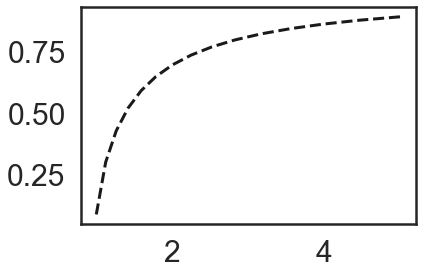

In [ ]:
plt.plot(R0s, (R0s-1)* np.log(R0s/(R0s-1)), 'k--', lw=3)

2.2884615384615388

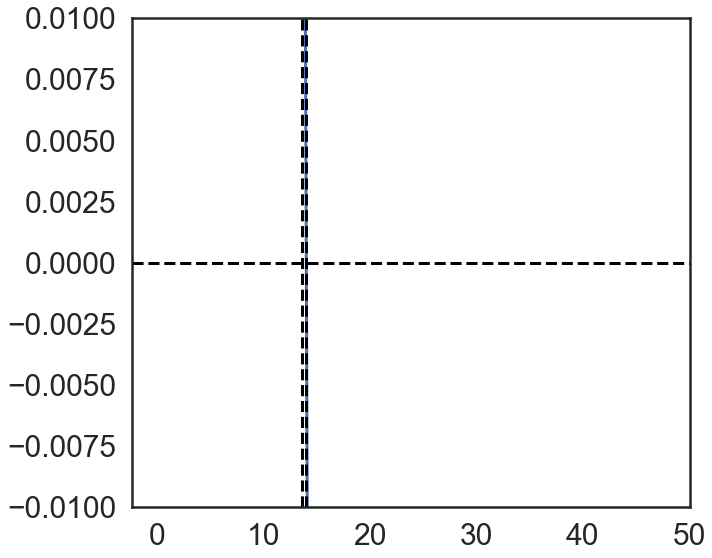

In [204]:
fig,ax =plt.subplots(1,figsize=(10,9))
plt.plot(ts, x - (R0-1)/R0)
ax.axhline(0,color='black',linestyle='--')
ax.set_ylim(-.01,.01)
ax.axvline(ts[solution_ind[0]],color='black',linestyle='--')
ax.axvline(tp,color='black',linestyle='--')

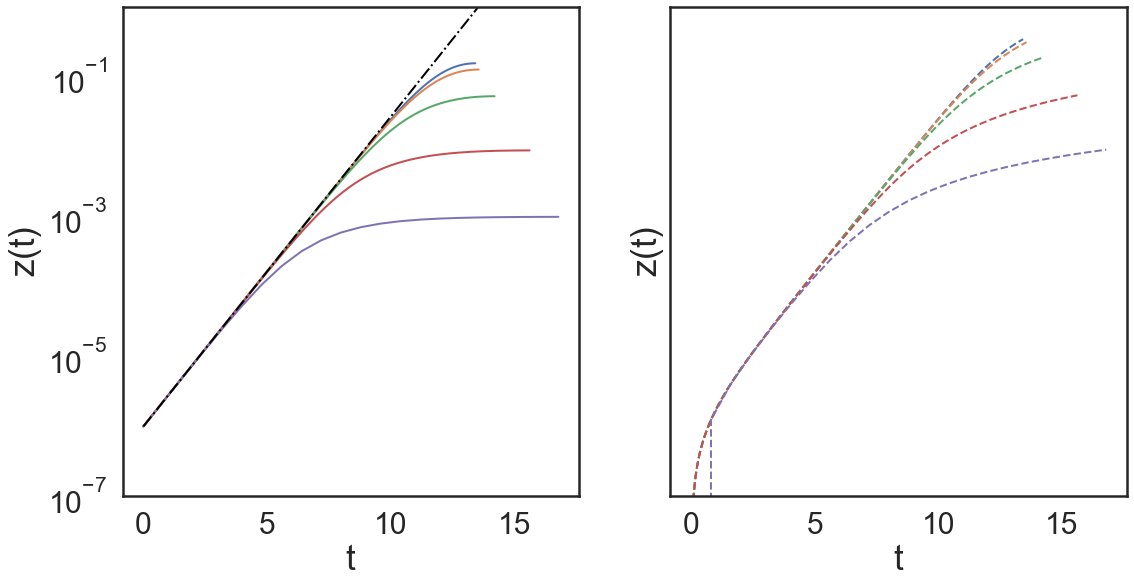

In [228]:
fig,ax =plt.subplots(1,2,figsize=(18,9),sharey=True ) 

for kappa in [0,1,10,100,1000]:
    ts=np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
    dt = ts[1]-ts[0]
    x,y,z= odeint(funcs.model, args= (R0,kappa), t = ts, y0 = y0).T
    tp,zp = ts[np.argmax(y)],z[np.argmax(y)]
    yp = y[np.argmax(y)]
    xp =  x[np.argmax(y)]



    lin, =  ax[0].plot(ts[ts<tp],y[ts<tp],lw=2)
    ax[1].plot(ts[ts<tp],z[ts<tp], color = lin.get_color(), linestyle='--',lw=2)

# ax.plot(ts[ts<tp]/tp, (y-y[0])[ts<tp]/(R0-1),linestyle='-.',color=lin.get_color())
ax[0].plot(ts[ts<tp],y0[1]*np.exp( (R0-1)*ts[ts<tp]),linestyle='-.',color='black',lw=2)
for a in ax:
    a.set_xlabel('$t$')
    a.set_ylabel('$z(t)$')
    # a.set_xscale('log')
    a.set_yscale('log')
    a.set_ylim(1/N,1)

In [ ]:
#zp = (1 + \[Kappa] - (R0 + \[Kappa])*((R0 + (-1 + R0)*\[Kappa])/R0**2)**(R0/(R0 - \[Kappa])))/\[Kappa]
zp_func = lambda R0,kappa: (1 + kappa - (R0 + kappa)*((R0 + (-1 + R0)*kappa)/R0**2)**(R0/(R0 - kappa)))/kappa
